In [1]:
import tensorflow as tf
import importlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
import torch
import utils4
import model2
importlib.reload(utils4)
importlib.reload(model2)
from utils4 import *
from model2 import *
tf.test.is_built_with_cuda()

True

In [2]:
icon_name_category, sketch_name_category = get_icons_and_sketches()
icon_dictionary, sketch_dictionary = load_icons_sketches_dic(icon_name_category, sketch_name_category)

positive_pairs = positive_pairs_generator(icon_name_category, sketch_name_category)
positive_pairs = shuffle(positive_pairs)

len_data = len(positive_pairs)
p_train=0.9
p_test=0.1
num_train = int(np.ceil(len_data*p_train))
num_test = int(np.floor(len_data*p_test))

positive_pairs_Train = positive_pairs[:num_train]
triplet_pairs_Train = triplets_generator(positive_pairs_Train, icon_name_category)
positive_pairs_Test = positive_pairs[-num_test:]
sketches_Test = positive_pairs_Test[:, [0, 1]]

icons_Test = positive_pairs_Test[:, [2, 3]]
# create the icons test dataset by removing the dublicates of the array
_, unique_indices = np.unique(icons_Test[:,0], return_index=True)
unique_icons_Test = icons_Test[unique_indices]

print(f'We have {len(triplet_pairs_Train)} samples in the training set.')
print(f'We have {len(sketches_Test)} sketches in the test set.')
print(f'We have {len(unique_icons_Test)} unique icons in the test set.')

We have 28626 samples in the training set.
We have 3180 sketches in the test set.
We have 1111 unique icons in the test set.


In [3]:
BATCH_SIZE = 128
num_epochs = 100
margin = 1
optimizer = tf.keras.optimizers.Adam(0.00001)
tf.keras.backend.set_floatx('float32')
siameseModel = mynet()

loss = triplet_loss

def train_step(sketches, positive_icons, negative_icons, margin):
    with tf.GradientTape() as tape:
        sketch_features = siameseModel(sketches, training = True)
        icon_positive_features = siameseModel(positive_icons, training = True) 
        icon_negative_features = siameseModel(negative_icons, training = True)   
        tape.watch(sketch_features)
        tape.watch(icon_positive_features)
        tape.watch(icon_negative_features)
        current_loss = loss(sketch_features, icon_positive_features, icon_negative_features, margin)
    grads = tape.gradient(current_loss, siameseModel.trainable_variables)
    optimizer.apply_gradients(zip(grads, siameseModel.trainable_variables))
    return current_loss

In [11]:
BATCH_SIZE = 4
num_epochs = 100
margin = 1
optimizer = tf.keras.optimizers.Adam(0.00001)
tf.keras.backend.set_floatx('float32')
iconClassificationModel = mynet()
iconClassificationModel.load_weights('Training-Weights/iconClassification').expect_partial()
sketchClassificationModel = mynet()
sketchClassificationModel.load_weights('Training-Weights/sketchClassification').expect_partial()

loss = triplet_loss

def train_step(sketches, positive_icons, negative_icons, margin):
    with tf.GradientTape(persistent=True) as tape:
        sketch_features = sketchClassificationModel(sketches, training = True)
        icon_positive_features = iconClassificationModel(positive_icons, training = True) 
        icon_negative_features = iconClassificationModel(negative_icons, training = True)   
        tape.watch(sketch_features)
        tape.watch(icon_positive_features)
        tape.watch(icon_negative_features)
        current_loss = loss(sketch_features, icon_positive_features, icon_negative_features, margin)
    grads = tape.gradient(current_loss, sketchClassificationModel.trainable_variables)
    optimizer.apply_gradients(zip(grads, sketchClassificationModel.trainable_variables))
    grads = tape.gradient(current_loss, iconClassificationModel.trainable_variables)
    optimizer.apply_gradients(zip(grads, iconClassificationModel.trainable_variables))
    return current_loss

In [12]:
for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    #training_set, test_set = create_datasets(sketch_icon_indices, positive_labels, Dataset)
    #trainloader, testloader = load_dataset()
    
    for i in range(0, len(triplet_pairs_Train), BATCH_SIZE):
        batch_triple_pairs = triplet_pairs_Train[i:i+BATCH_SIZE]
        sketches, positive_icons, negative_icons = get_batch(batch_triple_pairs, icon_dictionary, sketch_dictionary)
        loss_value = train_step(sketches, positive_icons, negative_icons, margin)
        epoch_loss_avg.update_state(loss_value)
    print("Epoch {:d}: Loss: {:.3f}".format(epoch,epoch_loss_avg.result()))
    if epoch%1==0:
        acc_1 = 0
        acc_10 = 0
        sketch_representations = []
        for j in range(0, len(sketches_Test), BATCH_SIZE):
            batch_sketches = sketches_Test[j:j+BATCH_SIZE]
            sketches_array = get_batch_sketches(batch_sketches)
            sketch_repr =  sketchClassificationModel(sketches_array, training = False)
            sketch_representations.append(sketch_repr)
        sketch_representations = np.vstack(sketch_representations)

        icon_representations = []
        for j in range(0, len(unique_icons_Test), BATCH_SIZE):
            batch_icons = unique_icons_Test[j:j+BATCH_SIZE]
            icons_array = get_batch_icons(batch_icons)
            icons_repr =  iconClassificationModel(icons_array, training = False)
            icon_representations.append(icons_repr)
        icon_representations = np.vstack(icon_representations)

        for k in range(len(sketch_representations)):
            sketch_repr = sketch_representations[k]
            sketch_representations_tile = np.tile(sketch_repr, len(unique_icons_Test)).reshape(len(unique_icons_Test), 64)
            diff = np.sqrt(np.mean((sketch_representations_tile - icon_representations)**2, -1))
            top_k = np.argsort(diff)[:10]
            
            for j in range(len(top_k)):
                index = top_k[j]
                if j == 0 and sketches_Test[k][0].split("_")[0] == unique_icons_Test[index][0].replace(".jpg",""):
                    acc_1 = acc_1 + 1
                    acc_10 = acc_10 + 1
                    break
                elif sketches_Test[k][0].split("_")[0] == unique_icons_Test[index][0].replace(".jpg",""):
                    acc_10 = acc_10 + 1
                    break
        print("Accuracy of top 1: " + str(acc_1/len(sketches_Test)))
        print("Accuracy of top 10: " + str(acc_10/len(sketches_Test)))
    triplet_pairs_Train = triplets_generator(positive_pairs_Train, icon_name_category)
    triplet_pairs_Train = shuffle(triplet_pairs_Train)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above. [Op:Conv2D]

[[0.        1.0810311 2.3904607 ... 0.        2.5684185 0.       ]
 [0.        1.0810311 2.3904607 ... 0.        2.5684185 0.       ]
 [0.        1.0810311 2.3904607 ... 0.        2.5684185 0.       ]
 ...
 [0.        1.0810311 2.3904607 ... 0.        2.5684185 0.       ]
 [0.        1.0810311 2.3904607 ... 0.        2.5684185 0.       ]
 [0.        1.0810311 2.3904607 ... 0.        2.5684185 0.       ]]


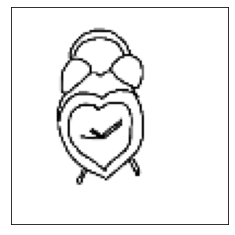

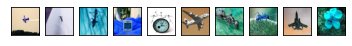

[[2.037213  0.        0.        ... 1.3418787 0.        0.7457687]
 [2.037213  0.        0.        ... 1.3418787 0.        0.7457687]
 [2.037213  0.        0.        ... 1.3418787 0.        0.7457687]
 ...
 [2.037213  0.        0.        ... 1.3418787 0.        0.7457687]
 [2.037213  0.        0.        ... 1.3418787 0.        0.7457687]
 [2.037213  0.        0.        ... 1.3418787 0.        0.7457687]]


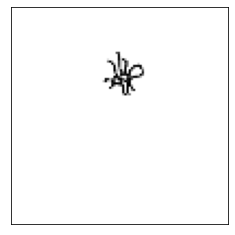

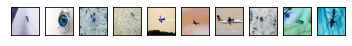

[[0.        0.        0.        ... 1.4084909 1.2227354 1.95159  ]
 [0.        0.        0.        ... 1.4084909 1.2227354 1.95159  ]
 [0.        0.        0.        ... 1.4084909 1.2227354 1.95159  ]
 ...
 [0.        0.        0.        ... 1.4084909 1.2227354 1.95159  ]
 [0.        0.        0.        ... 1.4084909 1.2227354 1.95159  ]
 [0.        0.        0.        ... 1.4084909 1.2227354 1.95159  ]]


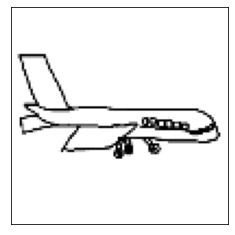

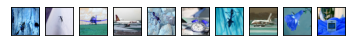

[[1.169274  1.2074733 0.        ... 3.084153  0.        2.5561829]
 [1.169274  1.2074733 0.        ... 3.084153  0.        2.5561829]
 [1.169274  1.2074733 0.        ... 3.084153  0.        2.5561829]
 ...
 [1.169274  1.2074733 0.        ... 3.084153  0.        2.5561829]
 [1.169274  1.2074733 0.        ... 3.084153  0.        2.5561829]
 [1.169274  1.2074733 0.        ... 3.084153  0.        2.5561829]]


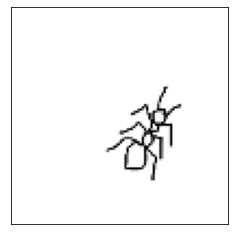

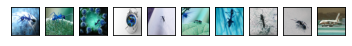

[[0.        0.        0.        ... 1.8828639 0.        0.       ]
 [0.        0.        0.        ... 1.8828639 0.        0.       ]
 [0.        0.        0.        ... 1.8828639 0.        0.       ]
 ...
 [0.        0.        0.        ... 1.8828639 0.        0.       ]
 [0.        0.        0.        ... 1.8828639 0.        0.       ]
 [0.        0.        0.        ... 1.8828639 0.        0.       ]]


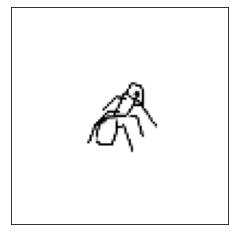

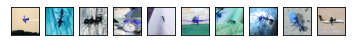

[[0.         0.         0.72250736 ... 1.5728194  1.3634886  0.        ]
 [0.         0.         0.72250736 ... 1.5728194  1.3634886  0.        ]
 [0.         0.         0.72250736 ... 1.5728194  1.3634886  0.        ]
 ...
 [0.         0.         0.72250736 ... 1.5728194  1.3634886  0.        ]
 [0.         0.         0.72250736 ... 1.5728194  1.3634886  0.        ]
 [0.         0.         0.72250736 ... 1.5728194  1.3634886  0.        ]]


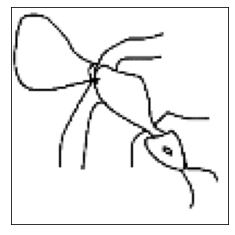

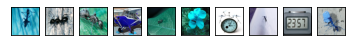

[[0.         0.         0.28240502 ... 3.524457   0.5947884  0.        ]
 [0.         0.         0.28240502 ... 3.524457   0.5947884  0.        ]
 [0.         0.         0.28240502 ... 3.524457   0.5947884  0.        ]
 ...
 [0.         0.         0.28240502 ... 3.524457   0.5947884  0.        ]
 [0.         0.         0.28240502 ... 3.524457   0.5947884  0.        ]
 [0.         0.         0.28240502 ... 3.524457   0.5947884  0.        ]]


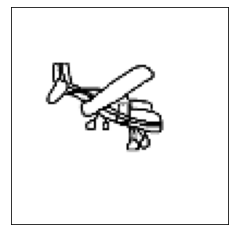

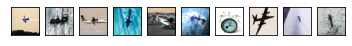

[[0.        0.        0.        ... 1.0089039 0.        0.       ]
 [0.        0.        0.        ... 1.0089039 0.        0.       ]
 [0.        0.        0.        ... 1.0089039 0.        0.       ]
 ...
 [0.        0.        0.        ... 1.0089039 0.        0.       ]
 [0.        0.        0.        ... 1.0089039 0.        0.       ]
 [0.        0.        0.        ... 1.0089039 0.        0.       ]]


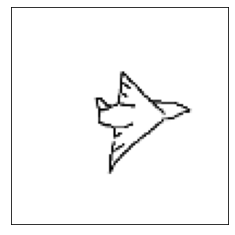

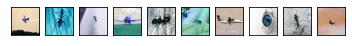

[[1.4241105  0.45630652 0.         ... 0.         0.06372908 0.        ]
 [1.4241105  0.45630652 0.         ... 0.         0.06372908 0.        ]
 [1.4241105  0.45630652 0.         ... 0.         0.06372908 0.        ]
 ...
 [1.4241105  0.45630652 0.         ... 0.         0.06372908 0.        ]
 [1.4241105  0.45630652 0.         ... 0.         0.06372908 0.        ]
 [1.4241105  0.45630652 0.         ... 0.         0.06372908 0.        ]]


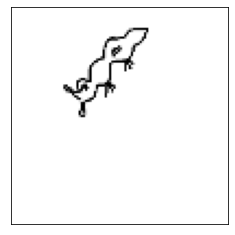

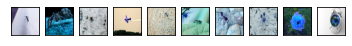

[[1.882706   0.         0.         ... 2.256734   0.         0.75800234]
 [1.882706   0.         0.         ... 2.256734   0.         0.75800234]
 [1.882706   0.         0.         ... 2.256734   0.         0.75800234]
 ...
 [1.882706   0.         0.         ... 2.256734   0.         0.75800234]
 [1.882706   0.         0.         ... 2.256734   0.         0.75800234]
 [1.882706   0.         0.         ... 2.256734   0.         0.75800234]]


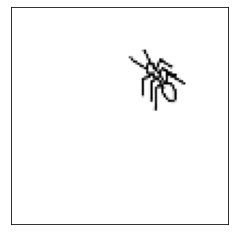

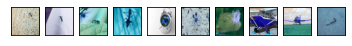

[[0.423136   0.90504307 0.         ... 0.45324552 1.5321075  0.35651508]
 [0.423136   0.90504307 0.         ... 0.45324552 1.5321075  0.35651508]
 [0.423136   0.90504307 0.         ... 0.45324552 1.5321075  0.35651508]
 ...
 [0.423136   0.90504307 0.         ... 0.45324552 1.5321075  0.35651508]
 [0.423136   0.90504307 0.         ... 0.45324552 1.5321075  0.35651508]
 [0.423136   0.90504307 0.         ... 0.45324552 1.5321075  0.35651508]]


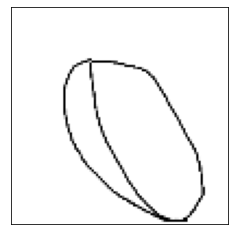

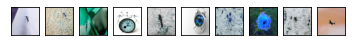

[[0.         0.         0.75689644 ... 0.48907787 1.0116224  0.        ]
 [0.         0.         0.75689644 ... 0.48907787 1.0116224  0.        ]
 [0.         0.         0.75689644 ... 0.48907787 1.0116224  0.        ]
 ...
 [0.         0.         0.75689644 ... 0.48907787 1.0116224  0.        ]
 [0.         0.         0.75689644 ... 0.48907787 1.0116224  0.        ]
 [0.         0.         0.75689644 ... 0.48907787 1.0116224  0.        ]]


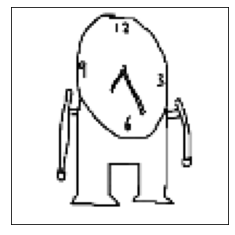

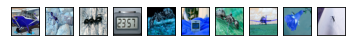

[[0.         0.         0.         ... 0.34783238 0.43747655 0.        ]
 [0.         0.         0.         ... 0.34783238 0.43747655 0.        ]
 [0.         0.         0.         ... 0.34783238 0.43747655 0.        ]
 ...
 [0.         0.         0.         ... 0.34783238 0.43747655 0.        ]
 [0.         0.         0.         ... 0.34783238 0.43747655 0.        ]
 [0.         0.         0.         ... 0.34783238 0.43747655 0.        ]]


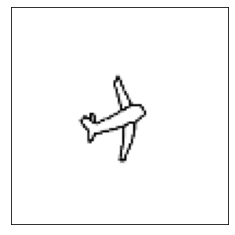

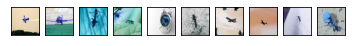

[[0.         0.13575344 0.6889091  ... 1.4319298  0.7046874  0.        ]
 [0.         0.13575344 0.6889091  ... 1.4319298  0.7046874  0.        ]
 [0.         0.13575344 0.6889091  ... 1.4319298  0.7046874  0.        ]
 ...
 [0.         0.13575344 0.6889091  ... 1.4319298  0.7046874  0.        ]
 [0.         0.13575344 0.6889091  ... 1.4319298  0.7046874  0.        ]
 [0.         0.13575344 0.6889091  ... 1.4319298  0.7046874  0.        ]]


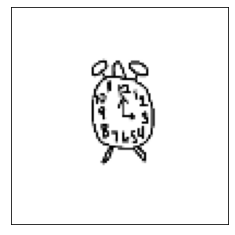

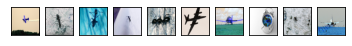

[[0.        0.        0.        ... 1.7884185 1.7089761 0.       ]
 [0.        0.        0.        ... 1.7884185 1.7089761 0.       ]
 [0.        0.        0.        ... 1.7884185 1.7089761 0.       ]
 ...
 [0.        0.        0.        ... 1.7884185 1.7089761 0.       ]
 [0.        0.        0.        ... 1.7884185 1.7089761 0.       ]
 [0.        0.        0.        ... 1.7884185 1.7089761 0.       ]]


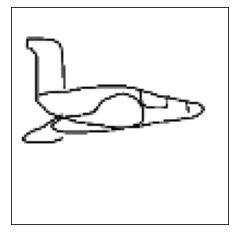

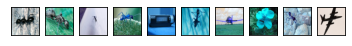

[[0.2022075 1.5162727 0.        ... 0.8110138 1.3219875 0.       ]
 [0.2022075 1.5162727 0.        ... 0.8110138 1.3219875 0.       ]
 [0.2022075 1.5162727 0.        ... 0.8110138 1.3219875 0.       ]
 ...
 [0.2022075 1.5162727 0.        ... 0.8110138 1.3219875 0.       ]
 [0.2022075 1.5162727 0.        ... 0.8110138 1.3219875 0.       ]
 [0.2022075 1.5162727 0.        ... 0.8110138 1.3219875 0.       ]]


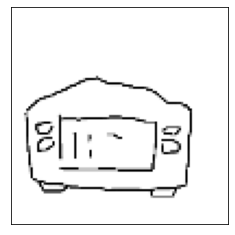

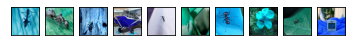

[[0.        0.        0.        ... 1.1181661 2.195025  0.       ]
 [0.        0.        0.        ... 1.1181661 2.195025  0.       ]
 [0.        0.        0.        ... 1.1181661 2.195025  0.       ]
 ...
 [0.        0.        0.        ... 1.1181661 2.195025  0.       ]
 [0.        0.        0.        ... 1.1181661 2.195025  0.       ]
 [0.        0.        0.        ... 1.1181661 2.195025  0.       ]]


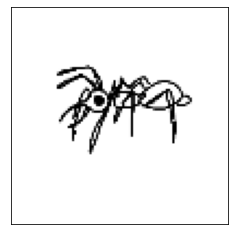

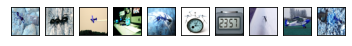

[[0.        0.        0.        ... 0.        1.6736026 0.       ]
 [0.        0.        0.        ... 0.        1.6736026 0.       ]
 [0.        0.        0.        ... 0.        1.6736026 0.       ]
 ...
 [0.        0.        0.        ... 0.        1.6736026 0.       ]
 [0.        0.        0.        ... 0.        1.6736026 0.       ]
 [0.        0.        0.        ... 0.        1.6736026 0.       ]]


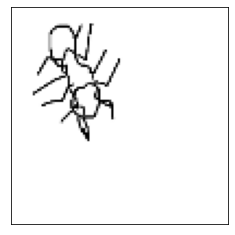

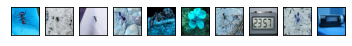

[[0.         0.         0.         ... 2.1868403  0.99235004 0.        ]
 [0.         0.         0.         ... 2.1868403  0.99235004 0.        ]
 [0.         0.         0.         ... 2.1868403  0.99235004 0.        ]
 ...
 [0.         0.         0.         ... 2.1868403  0.99235004 0.        ]
 [0.         0.         0.         ... 2.1868403  0.99235004 0.        ]
 [0.         0.         0.         ... 2.1868403  0.99235004 0.        ]]


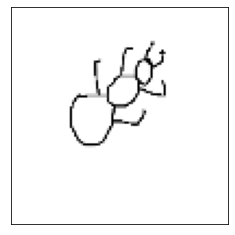

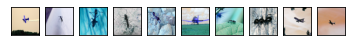

[[0.         0.         0.         ... 0.         0.31471696 0.        ]
 [0.         0.         0.         ... 0.         0.31471696 0.        ]
 [0.         0.         0.         ... 0.         0.31471696 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.31471696 0.        ]
 [0.         0.         0.         ... 0.         0.31471696 0.        ]
 [0.         0.         0.         ... 0.         0.31471696 0.        ]]


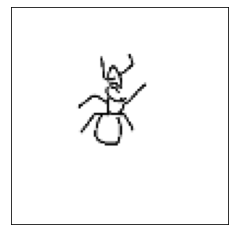

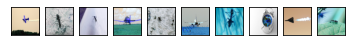

[[0.        1.7493567 0.0469373 ... 1.4350573 0.        0.       ]
 [0.        1.7493567 0.0469373 ... 1.4350573 0.        0.       ]
 [0.        1.7493567 0.0469373 ... 1.4350573 0.        0.       ]
 ...
 [0.        1.7493567 0.0469373 ... 1.4350573 0.        0.       ]
 [0.        1.7493567 0.0469373 ... 1.4350573 0.        0.       ]
 [0.        1.7493567 0.0469373 ... 1.4350573 0.        0.       ]]


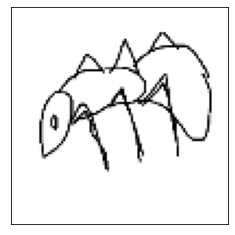

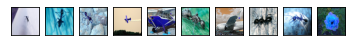

[[0.6495555  0.         0.         ... 0.09465462 1.5060829  0.        ]
 [0.6495555  0.         0.         ... 0.09465462 1.5060829  0.        ]
 [0.6495555  0.         0.         ... 0.09465462 1.5060829  0.        ]
 ...
 [0.6495555  0.         0.         ... 0.09465462 1.5060829  0.        ]
 [0.6495555  0.         0.         ... 0.09465462 1.5060829  0.        ]
 [0.6495555  0.         0.         ... 0.09465462 1.5060829  0.        ]]


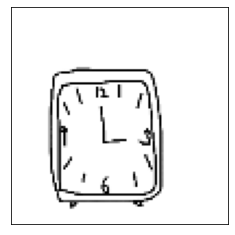

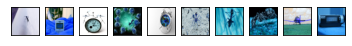

[[0.        0.        0.503331  ... 2.4140096 0.5662081 0.       ]
 [0.        0.        0.503331  ... 2.4140096 0.5662081 0.       ]
 [0.        0.        0.503331  ... 2.4140096 0.5662081 0.       ]
 ...
 [0.        0.        0.503331  ... 2.4140096 0.5662081 0.       ]
 [0.        0.        0.503331  ... 2.4140096 0.5662081 0.       ]
 [0.        0.        0.503331  ... 2.4140096 0.5662081 0.       ]]


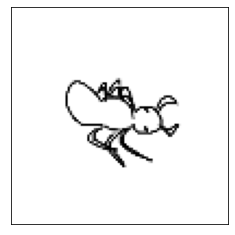

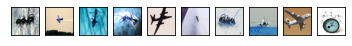

[[0.         0.42243287 0.         ... 1.4670144  0.9328332  0.        ]
 [0.         0.42243287 0.         ... 1.4670144  0.9328332  0.        ]
 [0.         0.42243287 0.         ... 1.4670144  0.9328332  0.        ]
 ...
 [0.         0.42243287 0.         ... 1.4670144  0.9328332  0.        ]
 [0.         0.42243287 0.         ... 1.4670144  0.9328332  0.        ]
 [0.         0.42243287 0.         ... 1.4670144  0.9328332  0.        ]]


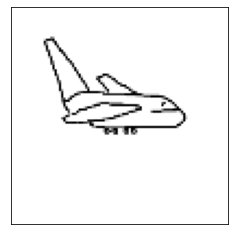

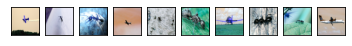

[[0.         0.         0.04925807 ... 0.60984486 0.28415158 0.        ]
 [0.         0.         0.04925807 ... 0.60984486 0.28415158 0.        ]
 [0.         0.         0.04925807 ... 0.60984486 0.28415158 0.        ]
 ...
 [0.         0.         0.04925807 ... 0.60984486 0.28415158 0.        ]
 [0.         0.         0.04925807 ... 0.60984486 0.28415158 0.        ]
 [0.         0.         0.04925807 ... 0.60984486 0.28415158 0.        ]]


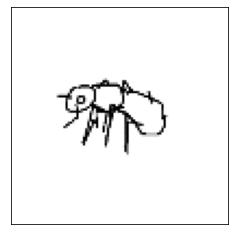

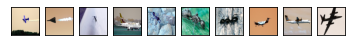

[[1.3500438  0.         0.         ... 0.62333274 1.1064491  0.        ]
 [1.3500438  0.         0.         ... 0.62333274 1.1064491  0.        ]
 [1.3500438  0.         0.         ... 0.62333274 1.1064491  0.        ]
 ...
 [1.3500438  0.         0.         ... 0.62333274 1.1064491  0.        ]
 [1.3500438  0.         0.         ... 0.62333274 1.1064491  0.        ]
 [1.3500438  0.         0.         ... 0.62333274 1.1064491  0.        ]]


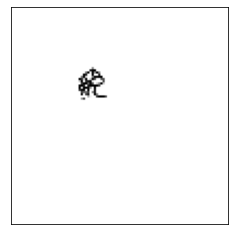

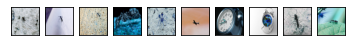

[[0.5507087  0.         0.         ... 0.11354893 0.9376759  0.        ]
 [0.5507087  0.         0.         ... 0.11354893 0.9376759  0.        ]
 [0.5507087  0.         0.         ... 0.11354893 0.9376759  0.        ]
 ...
 [0.5507087  0.         0.         ... 0.11354893 0.9376759  0.        ]
 [0.5507087  0.         0.         ... 0.11354893 0.9376759  0.        ]
 [0.5507087  0.         0.         ... 0.11354893 0.9376759  0.        ]]


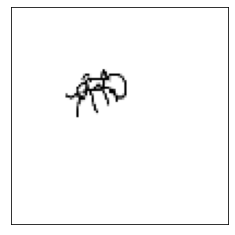

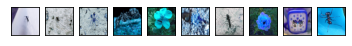

[[0.        0.        0.4033348 ... 1.2792188 1.0494256 0.       ]
 [0.        0.        0.4033348 ... 1.2792188 1.0494256 0.       ]
 [0.        0.        0.4033348 ... 1.2792188 1.0494256 0.       ]
 ...
 [0.        0.        0.4033348 ... 1.2792188 1.0494256 0.       ]
 [0.        0.        0.4033348 ... 1.2792188 1.0494256 0.       ]
 [0.        0.        0.4033348 ... 1.2792188 1.0494256 0.       ]]


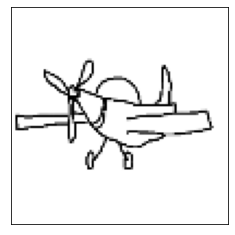

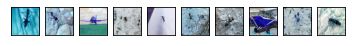

[[2.0260875  0.13132046 0.         ... 1.5909169  0.         0.715449  ]
 [2.0260875  0.13132046 0.         ... 1.5909169  0.         0.715449  ]
 [2.0260875  0.13132046 0.         ... 1.5909169  0.         0.715449  ]
 ...
 [2.0260875  0.13132046 0.         ... 1.5909169  0.         0.715449  ]
 [2.0260875  0.13132046 0.         ... 1.5909169  0.         0.715449  ]
 [2.0260875  0.13132046 0.         ... 1.5909169  0.         0.715449  ]]


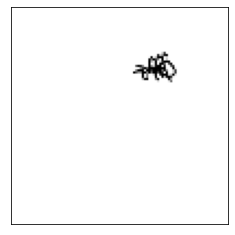

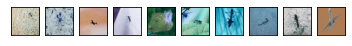

[[0.        0.        0.        ... 0.3747521 1.1853397 1.0604895]
 [0.        0.        0.        ... 0.3747521 1.1853397 1.0604895]
 [0.        0.        0.        ... 0.3747521 1.1853397 1.0604895]
 ...
 [0.        0.        0.        ... 0.3747521 1.1853397 1.0604895]
 [0.        0.        0.        ... 0.3747521 1.1853397 1.0604895]
 [0.        0.        0.        ... 0.3747521 1.1853397 1.0604895]]


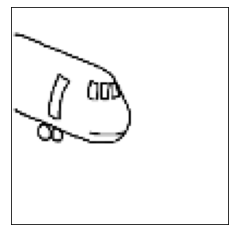

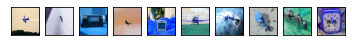

[[0.        0.7964764 0.        ... 0.        1.9127871 0.       ]
 [0.        0.7964764 0.        ... 0.        1.9127871 0.       ]
 [0.        0.7964764 0.        ... 0.        1.9127871 0.       ]
 ...
 [0.        0.7964764 0.        ... 0.        1.9127871 0.       ]
 [0.        0.7964764 0.        ... 0.        1.9127871 0.       ]
 [0.        0.7964764 0.        ... 0.        1.9127871 0.       ]]


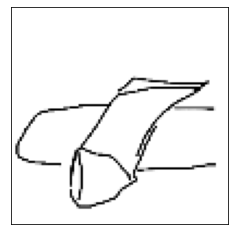

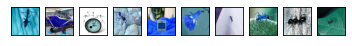

[[0.         1.3924791  0.54116917 ... 1.2506167  0.6698073  0.        ]
 [0.         1.3924791  0.54116917 ... 1.2506167  0.6698073  0.        ]
 [0.         1.3924791  0.54116917 ... 1.2506167  0.6698073  0.        ]
 ...
 [0.         1.3924791  0.54116917 ... 1.2506167  0.6698073  0.        ]
 [0.         1.3924791  0.54116917 ... 1.2506167  0.6698073  0.        ]
 [0.         1.3924791  0.54116917 ... 1.2506167  0.6698073  0.        ]]


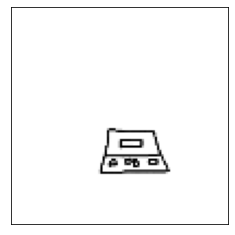

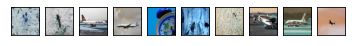

[[0.         0.         0.8320792  ... 0.41752315 2.2263997  0.14417988]
 [0.         0.         0.8320792  ... 0.41752315 2.2263997  0.14417988]
 [0.         0.         0.8320792  ... 0.41752315 2.2263997  0.14417988]
 ...
 [0.         0.         0.8320792  ... 0.41752315 2.2263997  0.14417988]
 [0.         0.         0.8320792  ... 0.41752315 2.2263997  0.14417988]
 [0.         0.         0.8320792  ... 0.41752315 2.2263997  0.14417988]]


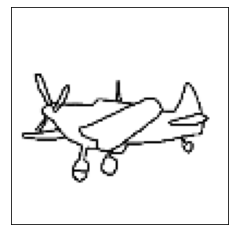

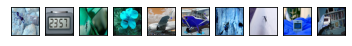

[[0.54830474 0.28276938 0.         ... 0.3072936  0.34065172 0.        ]
 [0.54830474 0.28276938 0.         ... 0.3072936  0.34065172 0.        ]
 [0.54830474 0.28276938 0.         ... 0.3072936  0.34065172 0.        ]
 ...
 [0.54830474 0.28276938 0.         ... 0.3072936  0.34065172 0.        ]
 [0.54830474 0.28276938 0.         ... 0.3072936  0.34065172 0.        ]
 [0.54830474 0.28276938 0.         ... 0.3072936  0.34065172 0.        ]]


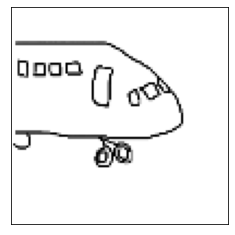

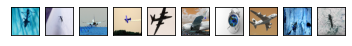

[[0.         0.02144729 0.21677758 ... 4.278949   0.         0.        ]
 [0.         0.02144729 0.21677758 ... 4.278949   0.         0.        ]
 [0.         0.02144729 0.21677758 ... 4.278949   0.         0.        ]
 ...
 [0.         0.02144729 0.21677758 ... 4.278949   0.         0.        ]
 [0.         0.02144729 0.21677758 ... 4.278949   0.         0.        ]
 [0.         0.02144729 0.21677758 ... 4.278949   0.         0.        ]]


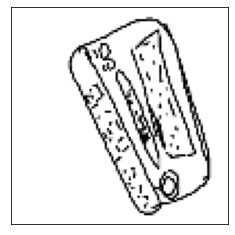

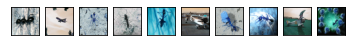

[[0.31432444 0.2285011  0.         ... 1.7537882  0.         0.        ]
 [0.31432444 0.2285011  0.         ... 1.7537882  0.         0.        ]
 [0.31432444 0.2285011  0.         ... 1.7537882  0.         0.        ]
 ...
 [0.31432444 0.2285011  0.         ... 1.7537882  0.         0.        ]
 [0.31432444 0.2285011  0.         ... 1.7537882  0.         0.        ]
 [0.31432444 0.2285011  0.         ... 1.7537882  0.         0.        ]]


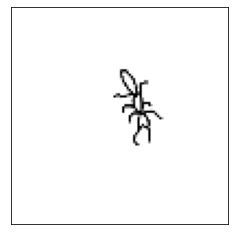

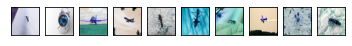

[[0.        0.        1.5578091 ... 0.        2.433455  0.       ]
 [0.        0.        1.5578091 ... 0.        2.433455  0.       ]
 [0.        0.        1.5578091 ... 0.        2.433455  0.       ]
 ...
 [0.        0.        1.5578091 ... 0.        2.433455  0.       ]
 [0.        0.        1.5578091 ... 0.        2.433455  0.       ]
 [0.        0.        1.5578091 ... 0.        2.433455  0.       ]]


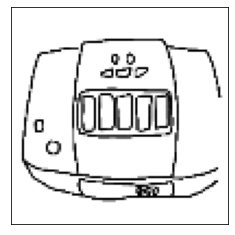

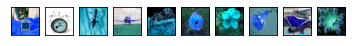

[[0.         0.         0.         ... 1.8408718  2.2978418  0.43580237]
 [0.         0.         0.         ... 1.8408718  2.2978418  0.43580237]
 [0.         0.         0.         ... 1.8408718  2.2978418  0.43580237]
 ...
 [0.         0.         0.         ... 1.8408718  2.2978418  0.43580237]
 [0.         0.         0.         ... 1.8408718  2.2978418  0.43580237]
 [0.         0.         0.         ... 1.8408718  2.2978418  0.43580237]]


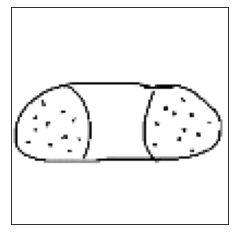

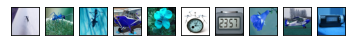

[[0.         1.2724638  0.40288574 ... 0.8316328  0.18705693 0.39835915]
 [0.         1.2724638  0.40288574 ... 0.8316328  0.18705693 0.39835915]
 [0.         1.2724638  0.40288574 ... 0.8316328  0.18705693 0.39835915]
 ...
 [0.         1.2724638  0.40288574 ... 0.8316328  0.18705693 0.39835915]
 [0.         1.2724638  0.40288574 ... 0.8316328  0.18705693 0.39835915]
 [0.         1.2724638  0.40288574 ... 0.8316328  0.18705693 0.39835915]]


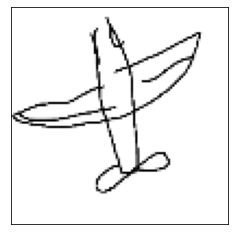

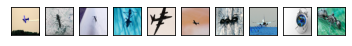

[[0.         0.         0.         ... 0.         2.408772   0.04747823]
 [0.         0.         0.         ... 0.         2.408772   0.04747823]
 [0.         0.         0.         ... 0.         2.408772   0.04747823]
 ...
 [0.         0.         0.         ... 0.         2.408772   0.04747823]
 [0.         0.         0.         ... 0.         2.408772   0.04747823]
 [0.         0.         0.         ... 0.         2.408772   0.04747823]]


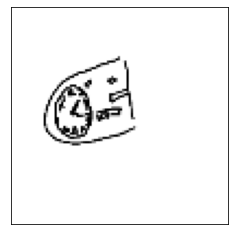

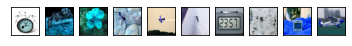

[[0.        0.0177099 0.        ... 0.1134218 0.3347213 0.       ]
 [0.        0.0177099 0.        ... 0.1134218 0.3347213 0.       ]
 [0.        0.0177099 0.        ... 0.1134218 0.3347213 0.       ]
 ...
 [0.        0.0177099 0.        ... 0.1134218 0.3347213 0.       ]
 [0.        0.0177099 0.        ... 0.1134218 0.3347213 0.       ]
 [0.        0.0177099 0.        ... 0.1134218 0.3347213 0.       ]]


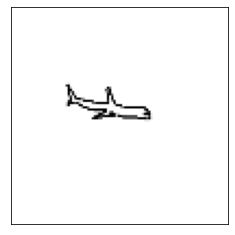

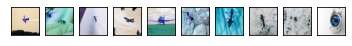

[[0.         0.05555557 0.70303553 ... 0.         1.2254258  0.32513532]
 [0.         0.05555557 0.70303553 ... 0.         1.2254258  0.32513532]
 [0.         0.05555557 0.70303553 ... 0.         1.2254258  0.32513532]
 ...
 [0.         0.05555557 0.70303553 ... 0.         1.2254258  0.32513532]
 [0.         0.05555557 0.70303553 ... 0.         1.2254258  0.32513532]
 [0.         0.05555557 0.70303553 ... 0.         1.2254258  0.32513532]]


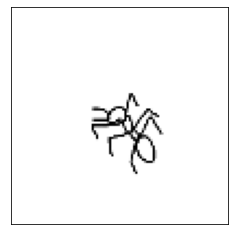

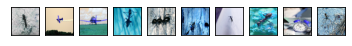

[[0.        0.        0.        ... 2.1105163 0.        0.       ]
 [0.        0.        0.        ... 2.1105163 0.        0.       ]
 [0.        0.        0.        ... 2.1105163 0.        0.       ]
 ...
 [0.        0.        0.        ... 2.1105163 0.        0.       ]
 [0.        0.        0.        ... 2.1105163 0.        0.       ]
 [0.        0.        0.        ... 2.1105163 0.        0.       ]]


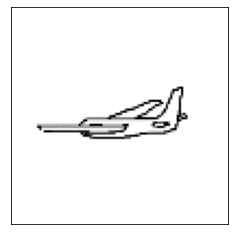

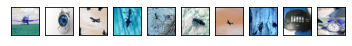

[[0.         0.         0.         ... 1.1785827  0.74493617 0.        ]
 [0.         0.         0.         ... 1.1785827  0.74493617 0.        ]
 [0.         0.         0.         ... 1.1785827  0.74493617 0.        ]
 ...
 [0.         0.         0.         ... 1.1785827  0.74493617 0.        ]
 [0.         0.         0.         ... 1.1785827  0.74493617 0.        ]
 [0.         0.         0.         ... 1.1785827  0.74493617 0.        ]]


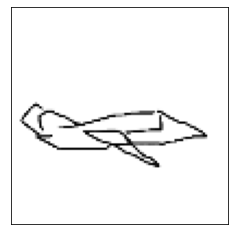

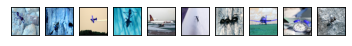

[[2.7526205  0.         0.         ... 1.2754295  0.37054387 0.        ]
 [2.7526205  0.         0.         ... 1.2754295  0.37054387 0.        ]
 [2.7526205  0.         0.         ... 1.2754295  0.37054387 0.        ]
 ...
 [2.7526205  0.         0.         ... 1.2754295  0.37054387 0.        ]
 [2.7526205  0.         0.         ... 1.2754295  0.37054387 0.        ]
 [2.7526205  0.         0.         ... 1.2754295  0.37054387 0.        ]]


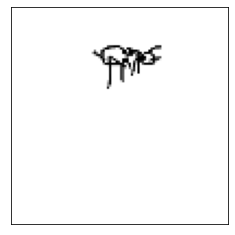

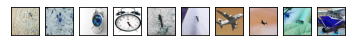

[[0.         0.4374087  0.17509319 ... 0.36155656 2.8775494  0.        ]
 [0.         0.4374087  0.17509319 ... 0.36155656 2.8775494  0.        ]
 [0.         0.4374087  0.17509319 ... 0.36155656 2.8775494  0.        ]
 ...
 [0.         0.4374087  0.17509319 ... 0.36155656 2.8775494  0.        ]
 [0.         0.4374087  0.17509319 ... 0.36155656 2.8775494  0.        ]
 [0.         0.4374087  0.17509319 ... 0.36155656 2.8775494  0.        ]]


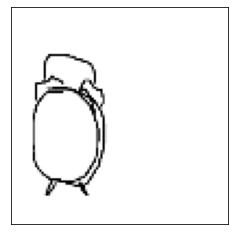

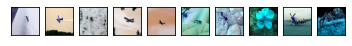

[[0.         0.34111047 0.         ... 0.         1.1720506  1.602792  ]
 [0.         0.34111047 0.         ... 0.         1.1720506  1.602792  ]
 [0.         0.34111047 0.         ... 0.         1.1720506  1.602792  ]
 ...
 [0.         0.34111047 0.         ... 0.         1.1720506  1.602792  ]
 [0.         0.34111047 0.         ... 0.         1.1720506  1.602792  ]
 [0.         0.34111047 0.         ... 0.         1.1720506  1.602792  ]]


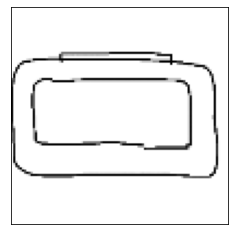

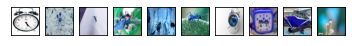

[[1.93479   0.        0.        ... 0.7306629 1.6376888 0.       ]
 [1.93479   0.        0.        ... 0.7306629 1.6376888 0.       ]
 [1.93479   0.        0.        ... 0.7306629 1.6376888 0.       ]
 ...
 [1.93479   0.        0.        ... 0.7306629 1.6376888 0.       ]
 [1.93479   0.        0.        ... 0.7306629 1.6376888 0.       ]
 [1.93479   0.        0.        ... 0.7306629 1.6376888 0.       ]]


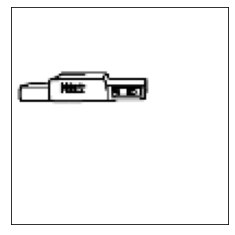

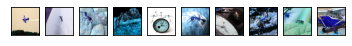

[[2.2352874  0.         0.         ... 1.0496966  0.51745766 0.32732546]
 [2.2352874  0.         0.         ... 1.0496966  0.51745766 0.32732546]
 [2.2352874  0.         0.         ... 1.0496966  0.51745766 0.32732546]
 ...
 [2.2352874  0.         0.         ... 1.0496966  0.51745766 0.32732546]
 [2.2352874  0.         0.         ... 1.0496966  0.51745766 0.32732546]
 [2.2352874  0.         0.         ... 1.0496966  0.51745766 0.32732546]]


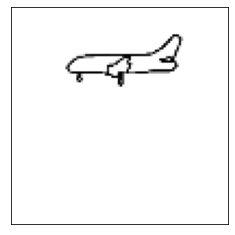

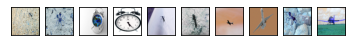

[[0.         2.0320997  1.2113414  ... 0.43798143 2.075817   0.        ]
 [0.         2.0320997  1.2113414  ... 0.43798143 2.075817   0.        ]
 [0.         2.0320997  1.2113414  ... 0.43798143 2.075817   0.        ]
 ...
 [0.         2.0320997  1.2113414  ... 0.43798143 2.075817   0.        ]
 [0.         2.0320997  1.2113414  ... 0.43798143 2.075817   0.        ]
 [0.         2.0320997  1.2113414  ... 0.43798143 2.075817   0.        ]]


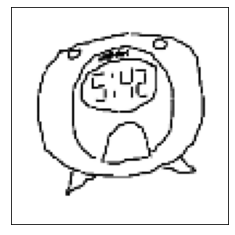

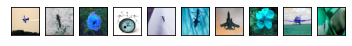

[[0.1627993 0.        1.2767936 ... 0.5015204 1.0334779 0.       ]
 [0.1627993 0.        1.2767936 ... 0.5015204 1.0334779 0.       ]
 [0.1627993 0.        1.2767936 ... 0.5015204 1.0334779 0.       ]
 ...
 [0.1627993 0.        1.2767936 ... 0.5015204 1.0334779 0.       ]
 [0.1627993 0.        1.2767936 ... 0.5015204 1.0334779 0.       ]
 [0.1627993 0.        1.2767936 ... 0.5015204 1.0334779 0.       ]]


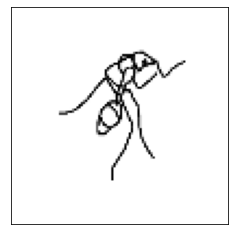

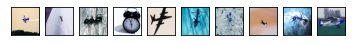

[[0.         0.09484141 0.         ... 1.1181825  1.0675027  0.        ]
 [0.         0.09484141 0.         ... 1.1181825  1.0675027  0.        ]
 [0.         0.09484141 0.         ... 1.1181825  1.0675027  0.        ]
 ...
 [0.         0.09484141 0.         ... 1.1181825  1.0675027  0.        ]
 [0.         0.09484141 0.         ... 1.1181825  1.0675027  0.        ]
 [0.         0.09484141 0.         ... 1.1181825  1.0675027  0.        ]]


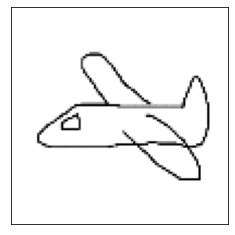

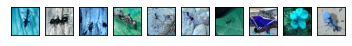

[[0.         0.         0.         ... 0.         0.         0.24341887]
 [0.         0.         0.         ... 0.         0.         0.24341887]
 [0.         0.         0.         ... 0.         0.         0.24341887]
 ...
 [0.         0.         0.         ... 0.         0.         0.24341887]
 [0.         0.         0.         ... 0.         0.         0.24341887]
 [0.         0.         0.         ... 0.         0.         0.24341887]]


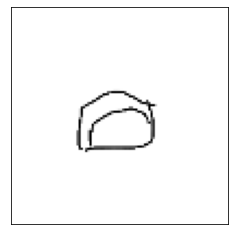

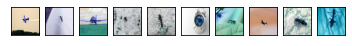

[[0.98459315 0.         0.         ... 0.7422585  1.2181833  0.        ]
 [0.98459315 0.         0.         ... 0.7422585  1.2181833  0.        ]
 [0.98459315 0.         0.         ... 0.7422585  1.2181833  0.        ]
 ...
 [0.98459315 0.         0.         ... 0.7422585  1.2181833  0.        ]
 [0.98459315 0.         0.         ... 0.7422585  1.2181833  0.        ]
 [0.98459315 0.         0.         ... 0.7422585  1.2181833  0.        ]]


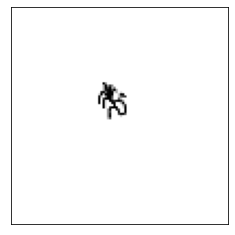

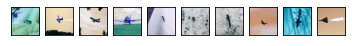

[[0.         0.         0.0198573  ... 0.43245274 0.80114615 0.        ]
 [0.         0.         0.0198573  ... 0.43245274 0.80114615 0.        ]
 [0.         0.         0.0198573  ... 0.43245274 0.80114615 0.        ]
 ...
 [0.         0.         0.0198573  ... 0.43245274 0.80114615 0.        ]
 [0.         0.         0.0198573  ... 0.43245274 0.80114615 0.        ]
 [0.         0.         0.0198573  ... 0.43245274 0.80114615 0.        ]]


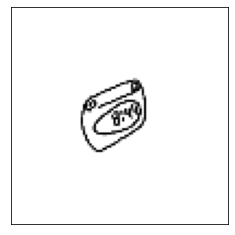

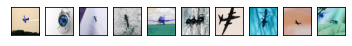

[[0.         0.         0.         ... 0.62123364 0.         0.        ]
 [0.         0.         0.         ... 0.62123364 0.         0.        ]
 [0.         0.         0.         ... 0.62123364 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.62123364 0.         0.        ]
 [0.         0.         0.         ... 0.62123364 0.         0.        ]
 [0.         0.         0.         ... 0.62123364 0.         0.        ]]


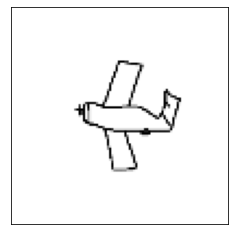

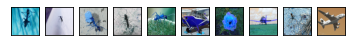

[[0.        0.        0.        ... 1.0076492 0.6342656 0.       ]
 [0.        0.        0.        ... 1.0076492 0.6342656 0.       ]
 [0.        0.        0.        ... 1.0076492 0.6342656 0.       ]
 ...
 [0.        0.        0.        ... 1.0076492 0.6342656 0.       ]
 [0.        0.        0.        ... 1.0076492 0.6342656 0.       ]
 [0.        0.        0.        ... 1.0076492 0.6342656 0.       ]]


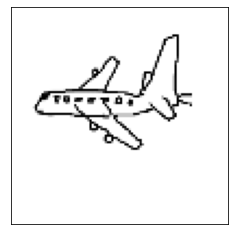

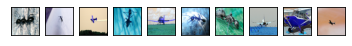

[[0.         0.06648105 0.8987438  ... 0.11508    2.4709878  0.        ]
 [0.         0.06648105 0.8987438  ... 0.11508    2.4709878  0.        ]
 [0.         0.06648105 0.8987438  ... 0.11508    2.4709878  0.        ]
 ...
 [0.         0.06648105 0.8987438  ... 0.11508    2.4709878  0.        ]
 [0.         0.06648105 0.8987438  ... 0.11508    2.4709878  0.        ]
 [0.         0.06648105 0.8987438  ... 0.11508    2.4709878  0.        ]]


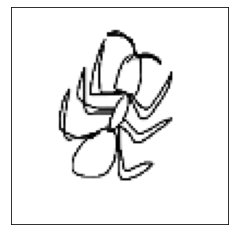

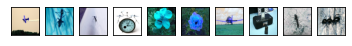

[[1.0237037 0.        0.        ... 0.        0.        0.       ]
 [1.0237037 0.        0.        ... 0.        0.        0.       ]
 [1.0237037 0.        0.        ... 0.        0.        0.       ]
 ...
 [1.0237037 0.        0.        ... 0.        0.        0.       ]
 [1.0237037 0.        0.        ... 0.        0.        0.       ]
 [1.0237037 0.        0.        ... 0.        0.        0.       ]]


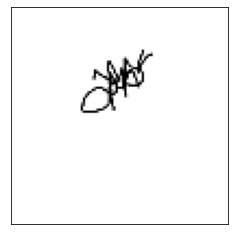

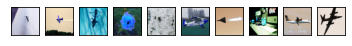

[[0.         0.         0.         ... 1.1419041  0.8033361  0.27907208]
 [0.         0.         0.         ... 1.1419041  0.8033361  0.27907208]
 [0.         0.         0.         ... 1.1419041  0.8033361  0.27907208]
 ...
 [0.         0.         0.         ... 1.1419041  0.8033361  0.27907208]
 [0.         0.         0.         ... 1.1419041  0.8033361  0.27907208]
 [0.         0.         0.         ... 1.1419041  0.8033361  0.27907208]]


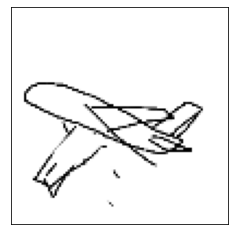

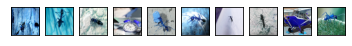

[[0.         0.01786094 0.         ... 0.07946634 1.6156229  0.5948394 ]
 [0.         0.01786094 0.         ... 0.07946634 1.6156229  0.5948394 ]
 [0.         0.01786094 0.         ... 0.07946634 1.6156229  0.5948394 ]
 ...
 [0.         0.01786094 0.         ... 0.07946634 1.6156229  0.5948394 ]
 [0.         0.01786094 0.         ... 0.07946634 1.6156229  0.5948394 ]
 [0.         0.01786094 0.         ... 0.07946634 1.6156229  0.5948394 ]]


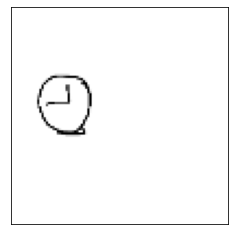

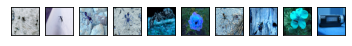

[[0.         0.         0.35629374 ... 0.         0.         0.        ]
 [0.         0.         0.35629374 ... 0.         0.         0.        ]
 [0.         0.         0.35629374 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.35629374 ... 0.         0.         0.        ]
 [0.         0.         0.35629374 ... 0.         0.         0.        ]
 [0.         0.         0.35629374 ... 0.         0.         0.        ]]


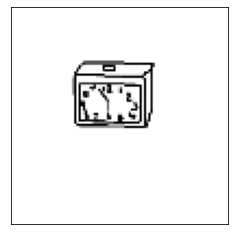

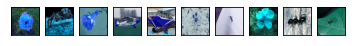

[[0.         0.35471472 0.12209369 ... 1.2038795  2.2371984  0.        ]
 [0.         0.35471472 0.12209369 ... 1.2038795  2.2371984  0.        ]
 [0.         0.35471472 0.12209369 ... 1.2038795  2.2371984  0.        ]
 ...
 [0.         0.35471472 0.12209369 ... 1.2038795  2.2371984  0.        ]
 [0.         0.35471472 0.12209369 ... 1.2038795  2.2371984  0.        ]
 [0.         0.35471472 0.12209369 ... 1.2038795  2.2371984  0.        ]]


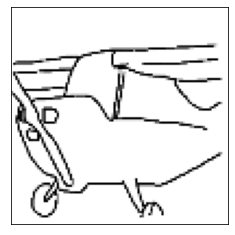

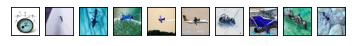

[[1.0439965  0.05707281 0.         ... 1.7836186  0.30070856 0.8540904 ]
 [1.0439965  0.05707281 0.         ... 1.7836186  0.30070856 0.8540904 ]
 [1.0439965  0.05707281 0.         ... 1.7836186  0.30070856 0.8540904 ]
 ...
 [1.0439965  0.05707281 0.         ... 1.7836186  0.30070856 0.8540904 ]
 [1.0439965  0.05707281 0.         ... 1.7836186  0.30070856 0.8540904 ]
 [1.0439965  0.05707281 0.         ... 1.7836186  0.30070856 0.8540904 ]]


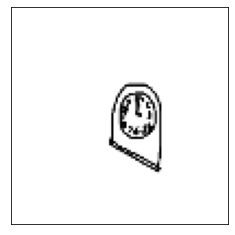

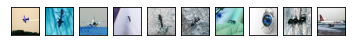

[[0.         0.         0.30849645 ... 0.85351056 2.8172576  0.        ]
 [0.         0.         0.30849645 ... 0.85351056 2.8172576  0.        ]
 [0.         0.         0.30849645 ... 0.85351056 2.8172576  0.        ]
 ...
 [0.         0.         0.30849645 ... 0.85351056 2.8172576  0.        ]
 [0.         0.         0.30849645 ... 0.85351056 2.8172576  0.        ]
 [0.         0.         0.30849645 ... 0.85351056 2.8172576  0.        ]]


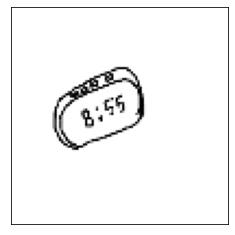

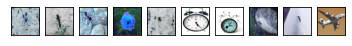

[[0.        0.        0.        ... 0.        1.6879082 0.       ]
 [0.        0.        0.        ... 0.        1.6879082 0.       ]
 [0.        0.        0.        ... 0.        1.6879082 0.       ]
 ...
 [0.        0.        0.        ... 0.        1.6879082 0.       ]
 [0.        0.        0.        ... 0.        1.6879082 0.       ]
 [0.        0.        0.        ... 0.        1.6879082 0.       ]]


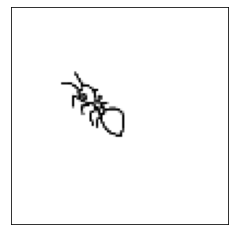

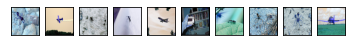

[[0.7723811  0.05852436 0.         ... 2.598323   0.         0.        ]
 [0.7723811  0.05852436 0.         ... 2.598323   0.         0.        ]
 [0.7723811  0.05852436 0.         ... 2.598323   0.         0.        ]
 ...
 [0.7723811  0.05852436 0.         ... 2.598323   0.         0.        ]
 [0.7723811  0.05852436 0.         ... 2.598323   0.         0.        ]
 [0.7723811  0.05852436 0.         ... 2.598323   0.         0.        ]]


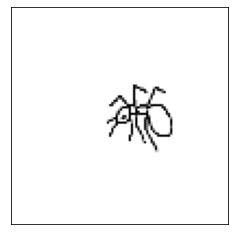

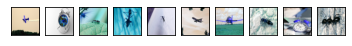

[[0.599651   0.4041177  0.23559542 ... 1.0449723  1.3728901  0.28518978]
 [0.599651   0.4041177  0.23559542 ... 1.0449723  1.3728901  0.28518978]
 [0.599651   0.4041177  0.23559542 ... 1.0449723  1.3728901  0.28518978]
 ...
 [0.599651   0.4041177  0.23559542 ... 1.0449723  1.3728901  0.28518978]
 [0.599651   0.4041177  0.23559542 ... 1.0449723  1.3728901  0.28518978]
 [0.599651   0.4041177  0.23559542 ... 1.0449723  1.3728901  0.28518978]]


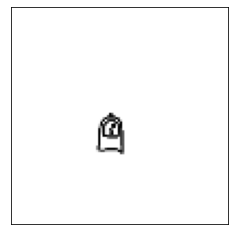

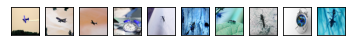

[[0.         0.         0.         ... 0.         0.44086453 0.        ]
 [0.         0.         0.         ... 0.         0.44086453 0.        ]
 [0.         0.         0.         ... 0.         0.44086453 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.44086453 0.        ]
 [0.         0.         0.         ... 0.         0.44086453 0.        ]
 [0.         0.         0.         ... 0.         0.44086453 0.        ]]


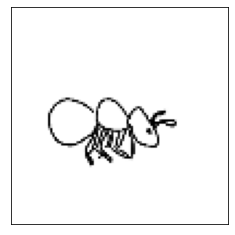

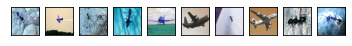

[[1.5019025  1.6424522  0.         ... 0.03477985 0.27644208 0.        ]
 [1.5019025  1.6424522  0.         ... 0.03477985 0.27644208 0.        ]
 [1.5019025  1.6424522  0.         ... 0.03477985 0.27644208 0.        ]
 ...
 [1.5019025  1.6424522  0.         ... 0.03477985 0.27644208 0.        ]
 [1.5019025  1.6424522  0.         ... 0.03477985 0.27644208 0.        ]
 [1.5019025  1.6424522  0.         ... 0.03477985 0.27644208 0.        ]]


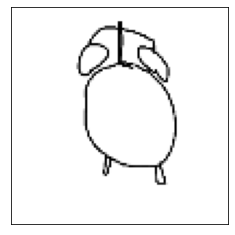

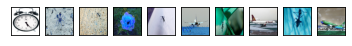

[[0.         1.2210939  1.2445804  ... 0.23255736 1.3312085  0.        ]
 [0.         1.2210939  1.2445804  ... 0.23255736 1.3312085  0.        ]
 [0.         1.2210939  1.2445804  ... 0.23255736 1.3312085  0.        ]
 ...
 [0.         1.2210939  1.2445804  ... 0.23255736 1.3312085  0.        ]
 [0.         1.2210939  1.2445804  ... 0.23255736 1.3312085  0.        ]
 [0.         1.2210939  1.2445804  ... 0.23255736 1.3312085  0.        ]]


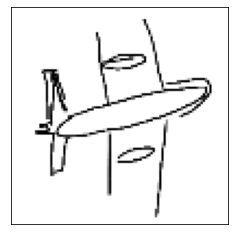

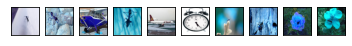

[[0.11074632 0.         0.13810088 ... 0.5194792  1.7974102  0.        ]
 [0.11074632 0.         0.13810088 ... 0.5194792  1.7974102  0.        ]
 [0.11074632 0.         0.13810088 ... 0.5194792  1.7974102  0.        ]
 ...
 [0.11074632 0.         0.13810088 ... 0.5194792  1.7974102  0.        ]
 [0.11074632 0.         0.13810088 ... 0.5194792  1.7974102  0.        ]
 [0.11074632 0.         0.13810088 ... 0.5194792  1.7974102  0.        ]]


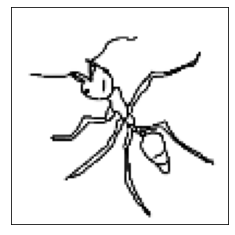

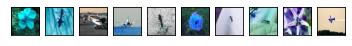

[[0.         0.37144855 0.         ... 1.8073031  1.778957   0.45875958]
 [0.         0.37144855 0.         ... 1.8073031  1.778957   0.45875958]
 [0.         0.37144855 0.         ... 1.8073031  1.778957   0.45875958]
 ...
 [0.         0.37144855 0.         ... 1.8073031  1.778957   0.45875958]
 [0.         0.37144855 0.         ... 1.8073031  1.778957   0.45875958]
 [0.         0.37144855 0.         ... 1.8073031  1.778957   0.45875958]]


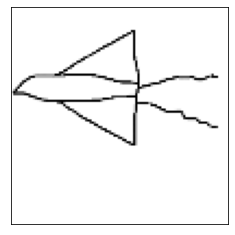

KeyboardInterrupt: 

In [9]:
if epoch%1==0:
    acc_1 = 0
    acc_10 = 0
    sketch_representations = []
    for j in range(0, len(sketches_Test), BATCH_SIZE):
        batch_sketches = sketches_Test[j:j+BATCH_SIZE]
        sketches_array = get_batch_sketches(batch_sketches)
        sketch_repr =  siameseModel(sketches_array, training = False)
        sketch_representations.append(sketch_repr)
    sketch_representations = np.vstack(sketch_representations)
    
    icon_representations = []
    for j in range(0, len(unique_icons_Test), BATCH_SIZE):
        batch_icons = unique_icons_Test[j:j+BATCH_SIZE]
        icons_array = get_batch_icons(batch_icons)
        icons_repr =  siameseModel(icons_array, training = False)
        icon_representations.append(icons_repr)

    icon_representations = np.vstack(icon_representations)

    for k in range(len(sketch_representations)):
        sketch_repr = sketch_representations[k]
        sketch_representations_tile = np.tile(sketch_repr, len(unique_icons_Test)).reshape(len(unique_icons_Test), 64)
        diff = np.sqrt(np.mean((sketch_representations_tile - icon_representations)**2, -1))
        top_k = np.argsort(diff)[:10]
        print(sketch_representations_tile)
        img = sketch_dictionary[sketches_Test[k][0]]
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.show()
        
        
        for j in range(len(top_k)):
            index = top_k[j]
            if j == 0 and sketches_Test[k][0].split("_")[0] == unique_icons_Test[index][0].replace(".jpg",""):
                acc_1 = acc_1 + 1
                acc_10 = acc_10 + 1
                #break
            elif sketches_Test[k][0].split("_")[0] == unique_icons_Test[index][0].replace(".jpg",""):
                acc_10 = acc_10 + 1
                #break
            img = icon_dictionary[unique_icons_Test[index][0]]
            plt.subplot(1, 10, j+1)
            plt.imshow(img)
            plt.xticks([])
            plt.yticks([])
        plt.show()     
    print("Accuracy of top 1: " + str(acc_1/len(sketches_Test)))
    print("Accuracy of top 10: " + str(acc_10/len(sketches_Test)))

            

[['wind_9.png' 'weather' 'wind.jpg' 'weather' 'moon.jpg' 'weather']
 ['spider_24.png' 'animals' 'spider.jpg' 'animals' 'horse-head.jpg'
  'animals']
 ['truck-monster_23.png' 'vehicles' 'truck-monster.jpg' 'vehicles'
  'bicycle.jpg' 'vehicles']
 ...
 ['ship_10.png' 'vehicles' 'ship.jpg' 'vehicles' 'bus.jpg' 'vehicles']
 ['motorcycle_8.png' 'vehicles' 'motorcycle.jpg' 'vehicles'
  'helicopter.jpg' 'vehicles']
 ['shuttle-van_16.png' 'vehicles' 'shuttle-van.jpg' 'vehicles' 'car.jpg'
  'vehicles']]
